# Module M4 -- Training linear models

This material is adapted from the book Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow by Geron Aurelien. 

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# How are models trained?

* So far we have seen how to use and apply different machine learning models

* However, we have not talked much about how they are actually trained

* We just call the mysterious .fit() or .fit_transform() function

* In this module, we will talk about ways to train a linear regression model.


# Linear Regression

Recall the linear regression model prediction equation:

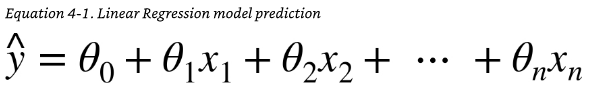

where:
* y_hat is the predicted value
* n is the number of features
* x<sub>i</sub> is the i<sup>th</sup> feature value
* theta_j is the j<sup>th</sup> model parameter
    * theta_0 is the bias term (the intercept)
    * theta_1 to theta_n are the feature weights

In other words, if we know the slope and intercept, we can predict the y-value for a given x-value.

Suppose:

theta_0 = 2
theta_1 = 4

Then our equation is:

y = 2 + 4 * x


#### Vectorized form 

In vectorized form Equation 4-1 is:

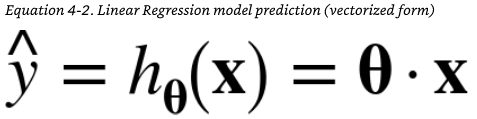

where:
* theta is the parameter vector for the model, containing:
    * the bias term theta_0
    * the feature weights theta_1 to theta_n
* x is the feature vector, containing:
    * x_0 to x_n
    * with x_0 always equal to 1
* theta dot x is the dot product of the vectors theta and x which is equal to



To train this model, we need to find parameters to minimize the error.

Recall that for linear regression, Root Mean Square Error (RMSE) is a common performance measure.

For simplicity here, we will use mean squared error (MSE), which will lead to the same result:

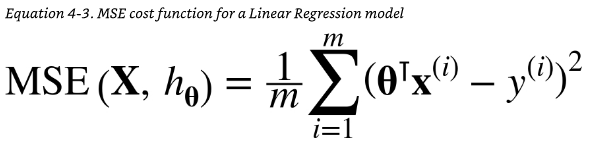


Our goal is to find a vector theta that minimizes the cost function.

Remember that theta is a vector with:
* theta_0 is the bias term (the intercept)
* theta_1 to theta_n are the feature weights




## The Normal Equation

One way we can find a theta that minimizes the cost function is to use a mathmatical formula that gives us the result directly.

The normal equation will do this:


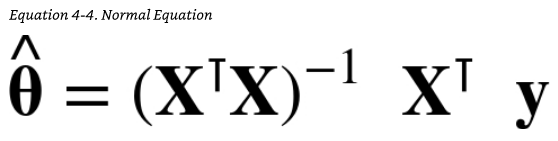

where:
* theta_hat is the value of theta that minimizes the cost function
* y is the vector of target values


We can test this out by generating some linear-ish data with randomness:
* we will use
    * theta_0 = 4
    * theta_1 = 3


In [ ]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

In [ ]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

In [ ]:
X[:10]

In [ ]:
y[:10]

In [ ]:
X_b = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each instance
X_b[:10]

#### Compute theta using the normal equation

So now that we have X_b and y, we can compute the solution directly using the normal equation:

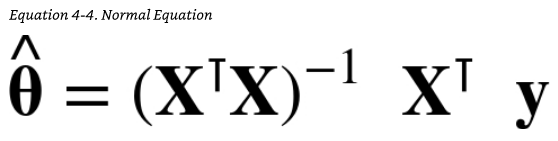



In [ ]:
# Apply the normal equation
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [ ]:
theta_best

In our original function, theta_0 = 4 and theta_1 = 3.

So we were close!

#### Use the solution to predict y for new instances

In [ ]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance
X_new_b

In [ ]:
y_predict = X_new_b.dot(theta_best)
y_predict

### Scikit-learn provides a LinearRegression model

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

In [ ]:
lin_reg.predict(X_new)

### Computational complexity

The normal equation computes the inverse of X<sup>T</sup>X
* this is an (n+1) x (n+1) matrix
* where n is the number of features

The computational complexity of doing this computation is typically O(n<sup>2.4</sup>) to O(n<sup>3</sup>).

The approach used by scikit-learn's LinearRegression class is about O(n<sup>2</sup>).

This means that *training* a LinearRegression model on a large number of features can be slow.

However, training is linear (O(n)) with regrad to the number of instances in the training set.

So large training sets are not too problematic.

Also...

Predictions using a linear regression model are linear both in terms of:
* the number of instances you are making predictions for
* the number of features


# Gradient Descent


* Gradient descent is an optimization algorithm

* It is one of the most important algorithms in machine learning

* The idea is to change parameters to try to minimize a cost function.

#### Basic idea
Imagine that you are standing on a mountain at night.

You can't see very far in front of you, but you can feel the slope of the ground.

What do you do?

One strategy would be to:
* feel around in several directions (N, S, E, W)
* see which direction had the steepest slope downward
* go in the direction of the steepest slope for a certain distance
* then repeat this process until we reach the bottom of the mountain

This is basically the idea of gradient descent!

In order to find a point of minimal error (the bottom of the mountain), we go in the direction of the steepest downward slope for some distance and then repeat this process until we get to the lowest point.


#### Visual examples

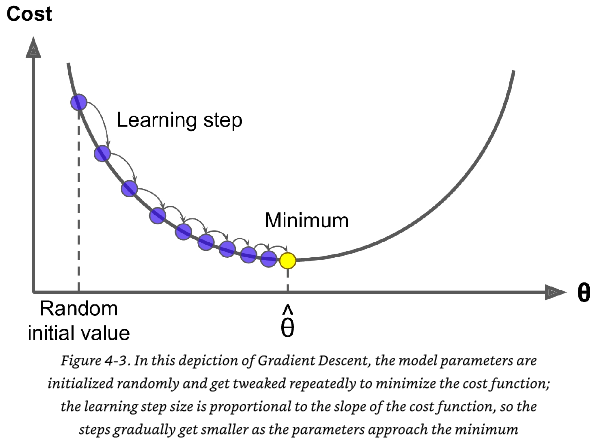

The *learning rate* is the size of the distance we travel before we check again.  Sometimes this is called the step size.

If we set the learning rate too high, we could jump around and never find the minimum:

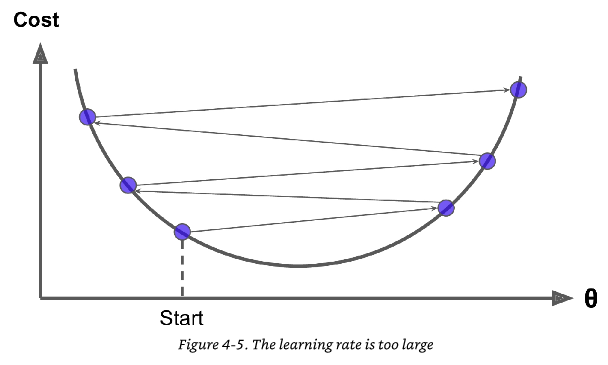

If the cost function has ridges, plateaus, etc. then we could end up in a sub-optimal local minimum:

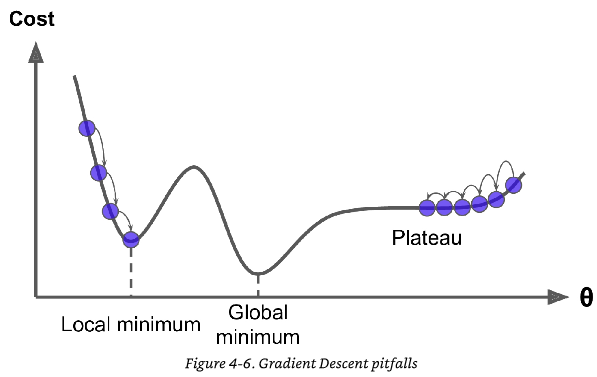

The good news is that for Linear Regression, the cost function is always a convex function (i.e. a bowl).





## Gradient Descent for a function with one variable
(material from:  https://medium.com/intuition/gradient-descent-visualization-285d3dd0fe00 )

Let's imagine that we have a simple function:  C(x) = x<sup>2</sup>

We imagine that we start at some point such as x = -8

We are trying to get to the lowest point (which in this case corresponds to x = 0)

If we are at some point x=-8, how can we determine the direction to go?

In other words, we need to compute the steepness of the slope.

We can do this with derivatives.   (oh no!  you didn't mention there would be calculus involved!)

Don't worry!

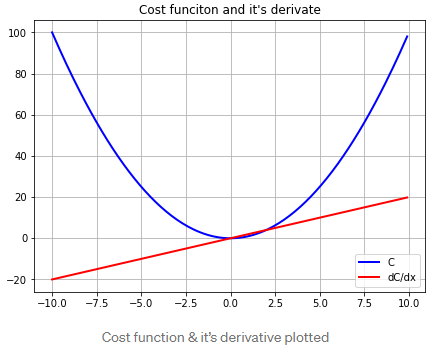


The derivative of C(x) = x<sup>2</sup> is just:   dC/dx = 2x

So if we plug in our x = -8, we see that 2(-8) = -16.

This indicates that we are on a downward slope, so to keep going downward we need to move right on the x-axis.

Imagine that we decide to take a step of size +4.  This takes us to:   x=-4.

Now dC/dx = 2x = 2(-4) = -8

So we are still on a downward slope, but it is less steep than it was back at x=-8.

So maybe this time we will not take such a big step to the right.

If we keep doing this, we will eventually get to a point where dC/dx = 0 (or very close to it).

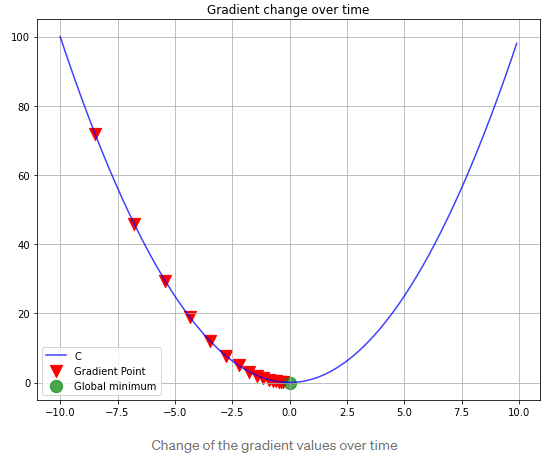



### Gradient Descent and feature scaling

For Linear Regression, the MSE cost function will always be in the shape of a bowl (i.e., a convex function).

This means we don't have to worry about getting stuck in a local minimum.

However, if the scale of the features is very different, we could end up with an elogated bowl.

This could lead to GD taking a long time to converge on the minimum.

Here is an example with two features:

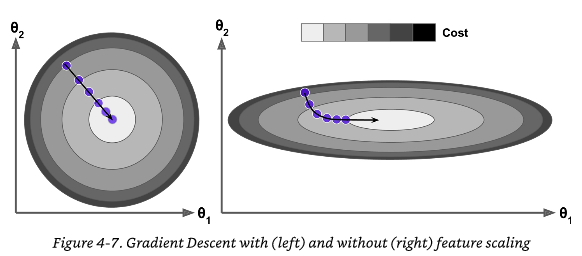

This illustrates that you should be sure to use feature scaling (e.g., scikit-learn's StandardScaler) when using GD.



## Batch Gradient Descent

As noted in the textbook:

* To implement Gradient Descent, you need to compute the gradient of the cost function with regard to each model parameter theta_j.
* How much will the cost function change if you change theta_j just a little bit?
* Since there are j features, we need to understand the change with respect to each feature.

To do this, we will use partial derivatives.

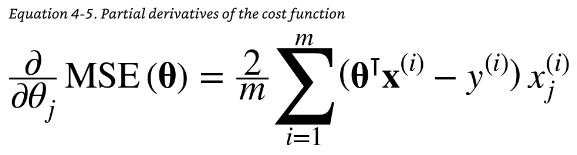


Recall our example about standing on top of a mountain at night.

We could imagine that we have four features (north, south, east, west).

Then we would need to:
* figure out the slope of the mountain if I'm facing north
* figure out the slope of the mountain if I'm facing south
* figure out the slope of the mountain if I'm facing east
* figure out the slope of the mountain if I'm facing west

We can compute all of these at once using a bit of matrix algebra:

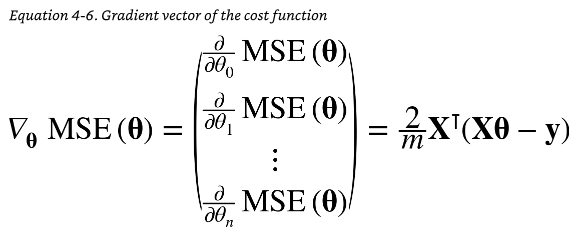

This computes the `gradient vector`.

Then, to go to the next step, we subtract the gradient vector from our current model parameters in theta.

We multiply the gradient vector by eta, the learning rate.

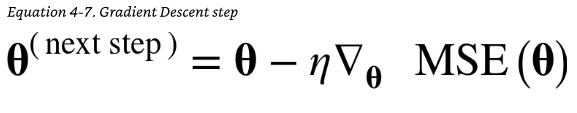

#### Batch Gradient Descent
* Note that in this approach, each gradient step involves calculations over the entire training set X.

* This is called batch gradient descent because it uses the whole batch of training data at each step.

* This can be slow on very large training sets.

* However, there are ways around this.


## Stochastic Gradient Descent

As we just noted, Batch GD uses the whole training set to compute the gradients at each step.

This can make it slow when the training set is large.

Stochastic GD addresses this by:
* selecting a random instance in the training set
* computing the gradients based only on that instance

This solves two issues:
* it can run faster since each iteration requires very little data
* it allows training on huge data sets, since only one instance needs to be in memory at each step

However, because we are using only one *random* instance at each step:
* the algorithm is less regular -- it will bounce around
* over time, it will get very close to the minimum, but it will continue to bounce around
* thus, we will find very good parameter values, but they will not be optimal

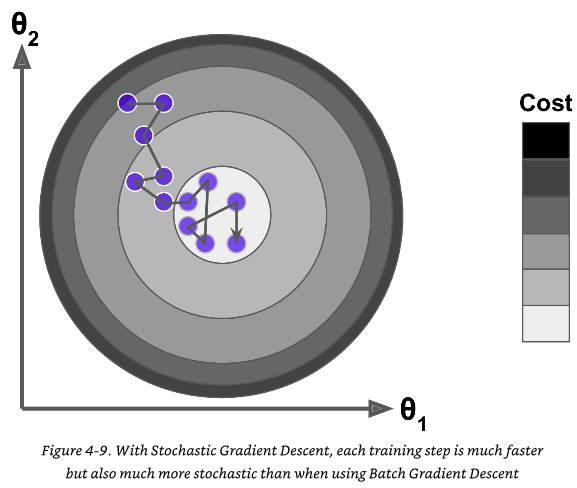

Often, Stochasitc GD uses an approach in which it starts with larger steps and decreases the step size across the iterations.

In other words, we have a *learning schedule* that adjusts the learning rate (eta) to get smaller.

Each iteration is called an epoch.

#### Stochastic GD requires independent and identically distributed training instances
Note that when using Stochastic GD, the training instances must be independent and identically distributed (IID).

One way to ensure this is to shuffle the instances.

#### Stochastic GD with scikit-learn

We can use the `SGDRegressor` class in scikit-learn to perform Linear Regression using Stochastic GD.

The code below:
* runs for a max of 1000 epochs (max_iter=1000)
* OR, until the loss drops by less than 0.001 during one epoch (tol=1e-3)
* starts with a learning rate of 0.1 (eta0=0.1)
* penalty=None means that it does not use any regularization


In [ ]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

In [ ]:
sgd_reg.intercept_, sgd_reg.coef_

## Mini-batch gradient descent

* At each step, instead of computing the gradients based on
    * the whole training set (Batch GD)
    * one random instance (Stochastic GD)

* Mini-batch computes the gradients based on small random sets called mini-batches.

The following figure illustates the paths taken by three GD algorithms during training:

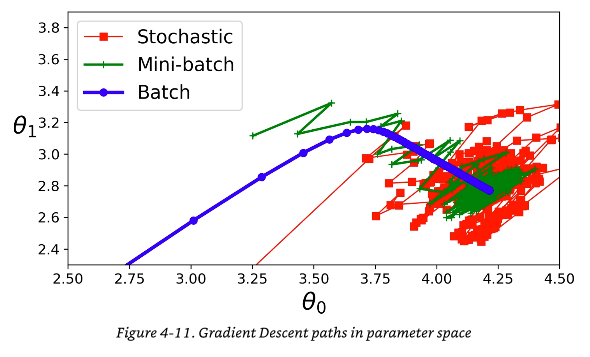


# Polynomial Regression

What if your data is not a straight line?

Maybe it is a curve.

Let's create an example.

Below is some data based on a quadratic equation plus some random noise.

The equation is:

1/2 x<sup>2</sup> + x + 2 + (random value from 0 to 1)


In [ ]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

In [ ]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

In [ ]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

As you can see, the data above is a curve.

A straight line will never be able to fit this data properly.

#### PolynomialFeatures class

One way we could address this would be to add powers of each feature as new features

And then train a linear model on this extended set of features.

scikit-learn provides a class `PolynomialFeatures` that will add the polynomial features to our data.

In our current example, we only have one feature:  x

So `PolynomialFeatures` will add one additional feature:  x<sup>2</sup>
    
And we can store this extended set of two features (x and x<sup>2</sup>) in an array called X_poly.


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

X_poly now contains x and x<sup>2</sup> for each instance

In [ ]:
X_poly[0]

Then, we can instantiate a scikit-learn LinearRegression() class

And train it with X_poly and y by calling .fit(X_poly, y)

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

The predicted model estimates:



where the original function was:



We can plot the predicted curve using matplotlib.

In [ ]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

#### Note
Note that when you have multiple features, PolynomialFeatures will add all combinations of features up to the given degree.

For example, if we had two features:  a  and  b

PolynomialFeatures with degree=3 would add:
* a<sup>2</sup>
* a<sup>3</sup>
* b<sup>2</sup>
* b<sup>3</sup>

and also
* ab
* a<sup>2</sup>b
* ab<sup>2</sup>

This allows Polynomial Regression to find relationships between features
(something that plain LinearRegression cannot do).

*However*, be careful!

PolynomialFeatures(degree=d) transforms an array with n features into

an array with (n+d)! / d!n! features

where n! is the factorial of n

This could lead to an explosion of the number of features!

# Learning Curves

High-degree Polynomial Regression is likely to fit training data much better than plain regression.

However, this can lead to overfitting.

The figure below illustrates this for three models:
* a 1-degree polynomial (a line)
* a 2-degree polynomial (quadratic curve)
* a 300-degree polynomial (severly overfitting)

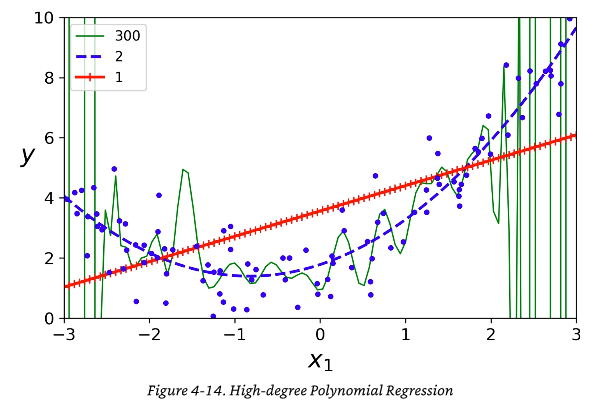


#### How to tell if a model is too simple or too complex?
Since we typically won't know what function generated our data, how do we know how complex our model should be?

Earlier, we talked about:
* if the model performs well on training data, but generalizes poorly in cross-validation, then the model is overfitting
* if it performs poorly on both, then it is underfitting

Another approach is to look at *learning curves*:
* these are plots of the model's performance on the training set and validation set as a function of the size of the training set

Here are the learning curves of the plain Linear Regression model (1-degree polynomial).

These curves indicate underfitting:
* both curves have reached a plaeau
* they are fairly close and fairly high

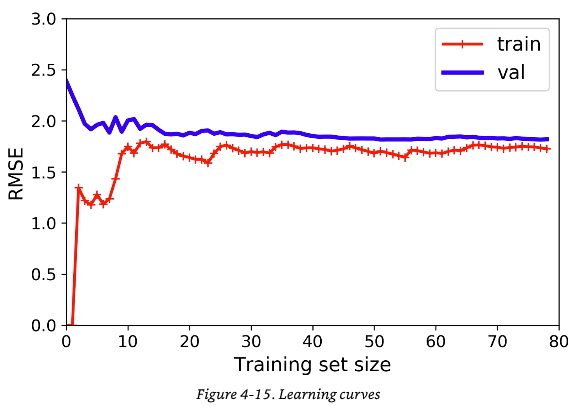


Next, let's look at the learning curves for a 10th-degree polynomial model on the same data.

Here, we see that:
* the error is much lower than with the Linear Regression model
* there is a gap between the curves, indicating overfitting

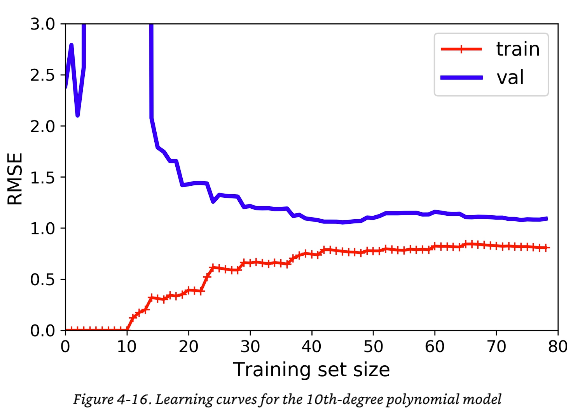


## Bias/Variance Trade-off

Error can be expressed as the sum of three very different types of errors:

* Bias
    * Error due to wrong assumptions
    * For example, assuming data is linear when it is actually quadratic
    * High-bias models will underfit the training data
* Variance
    * the model's sensitivity to small variations in the training data
    * a model with many degrees of freedom is likely to have high variance and thus overfit
* Irreducible error
    * error that is due to the noisiness of the data itself
    * the only way to reduce this is to clean up the data
        * fix broken sensors, detect and remove outliers
        
Typically:
* increasing a model's complexity will increase its variance and reduce its bias
* reducing a model's complexity will increase its bias and reduce its variance